In [1]:
import librosa
import tensorflow as tf
import os
from keras import Sequential
from keras.layers import Dense, LSTM, Input, Dropout, concatenate
from keras import layers
import keras
import numpy as np
import librosa
import matplotlib.pyplot as plt
import time
import soundfile
from IPython.display import Audio as IAudio

timestep = 2**9
sr = 2**14

In [2]:
def load_song(path,sr=2**14,timestep=timestep):
    track,_ = librosa.load(path,sr=sr)
    num_slices = track.shape[0]//timestep
    track = track[:num_slices*timestep]
    track = track.reshape((-1,timestep))
    return track

In [3]:
cross_entropy_artist = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy_critic = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def critic_loss(real_output, fake_output):
    real_loss = cross_entropy_critic(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_critic(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def artist_loss(fake_output):
    return cross_entropy_artist(tf.ones_like(fake_output),fake_output)

In [4]:
artist_optimizer = tf.keras.optimizers.Adam(1e-4)
critic_optimizer = tf.keras.optimizers.Adam(1e-4)

In [5]:
def song_iteration(num_seconds = 8,sr=2**14,timestep=2**11,batch_size=1):
    num_steps = int(num_seconds*sr/timestep)
    
    track_path = 'tracks/' + os.listdir('tracks')[np.random.randint(0,len(os.listdir('tracks')))]
    real_track = load_song(track_path,sr=sr,timestep=timestep)
    beginpts =  np.random.randint(1,real_track.shape[0]-num_steps,batch_size)
    
    initial_sound = tf.convert_to_tensor([real_track[beginpt-1] for beginpt in beginpts])
    initial_probability = tf.ones([batch_size,timestep])/2
    art_output, crit_output = train_step(music_sample = initial_sound, previous_artist_output = initial_sound, 
               previous_critic_chances = [initial_probability]*2,batch_size=batch_size)
    
    for i in range(num_steps):
        curr_slice = tf.convert_to_tensor([real_track[beginpt+i] for beginpt in beginpts])
        art_output, crit_output = train_step(music_sample = curr_slice,previous_artist_output=art_output,
                                            previous_critic_chances = crit_output,batch_size=batch_size)
    
    


In [6]:
@tf.function
def train_step( music_sample, previous_artist_output, previous_critic_chances,batch_size = 1):
    #Me aseguro de que las entradas tengan 2 dimensiones
    music_sample = tf.reshape( tf.convert_to_tensor(music_sample),[batch_size,-1])
    previous_artist_output = tf.reshape( tf.convert_to_tensor(previous_artist_output) ,[batch_size,-1])
    previous_critic_chances = [tf.reshape( tf.convert_to_tensor(chances) ,[batch_size,-1]) for chances in previous_critic_chances]
    
    with tf.GradientTape() as art_tape , tf.GradientTape() as crit_tape:
        #Calculo las salidas del artista
        art_tape.watch(previous_artist_output)
        art_output = artist(previous_artist_output, training = True)
        
        
        #Calculo las probabilidades del crítico
        crit_tape.watch(music_sample)
        crit_tape.watch(previous_critic_chances)
        crit_tape.watch(art_output)
        real_output = critic([music_sample,previous_critic_chances[0]],training=True)
        fake_output = critic([art_output,previous_critic_chances[1]],training=True)
        
        #Calculo las losses
        art_loss = artist_loss(fake_output)
        crit_loss = critic_loss(real_output,fake_output) 
        

            
    gradients_of_artist = art_tape.gradient(art_loss, artist.trainable_variables)
    gradients_of_critic = crit_tape.gradient(crit_loss, critic.trainable_variables)

    artist_optimizer.apply_gradients(zip(gradients_of_artist, artist.trainable_variables))
    critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
    
    return art_output, [real_output,fake_output]

In [7]:
NN_per_layer_critic = 2**9
NN_per_layer_artist = 2**10

artist = Sequential()

artist.add(Input(shape=(timestep,)))
artist.add(Dense(NN_per_layer_artist,activation='tanh'))
artist.add(Dense(NN_per_layer_artist,activation='tanh'))
artist.add(Dense(NN_per_layer_artist,activation='tanh'))
artist.add(Dense(timestep,activation='tanh'))


#Critico
input_1 = Input(shape=(timestep,))
dense_1 = Dense(NN_per_layer_critic,activation='tanh')(input_1)

input_2 = Input(shape=(timestep,))
dense_2 = Dense(NN_per_layer_critic,activation='tanh')(input_2)

merged = concatenate([dense_1,dense_2])

MD_1 = Dense(NN_per_layer_critic,activation='sigmoid')(merged)
MD_2 = Dense(NN_per_layer_critic,activation='sigmoid')(MD_1)
MD_3 = Dense(timestep,activation='sigmoid')(MD_2)

critic = tf.keras.models.Model(inputs=[input_1,input_2],outputs = MD_3)


In [8]:
artist.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
Total params: 3,149,312
Trainable params: 3,149,312
Non-trainable params: 0
_________________________________________________________________


In [9]:
def decide_track(track):
    track = np.array(track).reshape(-1)
    num_slices = track.shape[0]//timestep
    track = track[:num_slices*timestep]
    track = track.reshape((-1,timestep))
    curr_chances = np.ones(timestep)/2
    preds = []
    for i in range(track.shape[0]):
        chances = critic.predict([track[i].reshape(1,-1), curr_chances.reshape(1,-1)])
        preds.append(chances)
        curr_chances=chances
    preds = np.array(preds).reshape(-1)
    return np.mean(preds), preds

def continue_sample(initial_sample,num_seconds):
    num_steps = int(num_seconds*sr/timestep)
    track = [initial_sample.reshape(-1)]
    for i in range(1,num_steps):
        track.append(artist.predict(track[-1].reshape(1,-1)).reshape(-1))
    
    return track


In [10]:
for i in range(1001):
    song_iteration(timestep=timestep,num_seconds=1,batch_size = 128)
    
    if i%50 == 0:
        
        print('Current Iteration: ' + str(i))
        
        track_path = 'tracks/' + os.listdir('tracks')[np.random.randint(0,len(os.listdir('tracks')))]
        print(track_path)
        real_track = load_song(track_path,sr=sr,timestep=timestep)
        fake_track = continue_sample(real_track[0],4)
        white_noise = np.random.randn(128*timestep)
        
        real_mean, _ = decide_track(real_track[:128])
        fake_mean, _ = decide_track(fake_track)
        noise_mean, _ = decide_track(white_noise)
        
        artist.save_weights('artist')
        critic.save_weights('critic')      
        
        
        print('Real Track Mean: ' + str(real_mean))
        print('Fake Track Mean: ' + str(fake_mean))
        print('White Noise Mean: ' + str(noise_mean))
        
        soundfile.write('test-' + str(i) + '.wav',np.array(fake_track).reshape(-1),samplerate=2**14,format='WAV')

        print(time.ctime())
        time.sleep(1)
    
        

C:\Users\Felix\anaconda3\envs\Spoti\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Current Iteration: 0
tracks/Your Love Is Evil.mp3


C:\Users\Felix\anaconda3\envs\Spoti\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Real Track Mean: 0.5004528
Fake Track Mean: 0.50055563
White Noise Mean: 0.50048923
Mon Jan 31 17:37:14 2022
Current Iteration: 50
tracks/シック・フリック.mp3
Real Track Mean: 0.83143294
Fake Track Mean: 0.1925016
White Noise Mean: 0.48166177
Mon Jan 31 17:38:59 2022
Current Iteration: 100
tracks/俺は怪獣.mp3
Real Track Mean: 0.96077865
Fake Track Mean: 0.9080344
White Noise Mean: 0.10613704
Mon Jan 31 17:40:44 2022
Current Iteration: 150
tracks/Seasons (Live at Loud Park Festival 2014).mp3
Real Track Mean: 0.9854392
Fake Track Mean: 0.9349244
White Noise Mean: 0.0806819
Mon Jan 31 17:42:31 2022
Current Iteration: 200
tracks/Easton Hope.mp3
Real Track Mean: 0.28785086
Fake Track Mean: 0.23998183
White Noise Mean: 0.23160785
Mon Jan 31 17:44:17 2022
Current Iteration: 250
tracks/Scales of Justice - The Wicked Symphony.mp3
Real Track Mean: 0.8937712
Fake Track Mean: 0.17659992
White Noise Mean: 0.057599258
Mon Jan 31 17:46:02 2022
Current Iteration: 300
tracks/レクイエム・フォー・ア・ドリーム.mp3
Real Track Mean: 0

In [114]:
track_path = 'testtracks//' + os.listdir('testtracks')[np.random.randint(0,len(os.listdir('tracks')))]
real_track = load_song(track_path,sr=sr,timestep=timestep)

In [115]:
mean, preds = decide_track(real_track.reshape(-1))

In [117]:
print(mean)

0.99999994


In [122]:
    artist.save_weights('artist')
    critic.save_weights('critic')

(20, 512)
0.00015046375


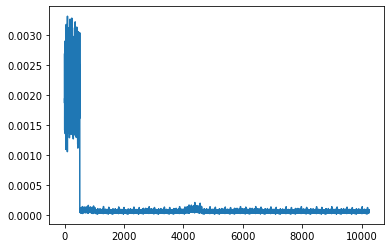

In [68]:
noise = np.random.randn(20,timestep)
noise_mean, noise_preds = decide_track(noise.reshape(-1))
plt.plot(noise_preds)

In [94]:
real_track[0]

array([-9.89606604e-03, -3.48844454e-02, -1.54255986e-01, -1.45040184e-01,
       -9.75666344e-02, -8.83318707e-02,  2.67899176e-03,  3.95892635e-02,
       -1.03267897e-02, -6.27748966e-02, -2.56855059e-02, -4.55624945e-02,
       -8.92377123e-02, -2.56260354e-02, -3.03921867e-02,  7.10760653e-02,
        1.17263973e-01, -2.39401534e-02,  1.93172935e-02,  4.77312924e-03,
       -4.91303094e-02,  5.38699776e-02,  1.76681802e-02, -1.26921143e-02,
        4.12927419e-02, -3.61900702e-02, -2.76700016e-02, -4.99194749e-02,
       -2.01192021e-01, -1.53740600e-01, -5.94829395e-02, -8.88409391e-02,
       -1.56757727e-01, -8.30123425e-02,  2.74484679e-02, -3.55383679e-02,
       -2.28797328e-02,  4.11205031e-02,  2.15657484e-02,  9.56894234e-02,
        2.62901839e-02, -4.95033599e-02, -1.10375602e-02, -4.17873450e-02,
        3.02996533e-03,  7.08549619e-02,  9.46206376e-02, -3.50484252e-03,
       -1.96338594e-02, -8.22838843e-02, -1.69058457e-01, -4.55520339e-02,
        2.64105108e-03, -

In [96]:
newtrack = continue_sample(real_track[0],num_seconds = 10)

In [98]:
np.array(newtrack[0]).reshape(-1)

array([-9.89606604e-03, -3.48844454e-02, -1.54255986e-01, -1.45040184e-01,
       -9.75666344e-02, -8.83318707e-02,  2.67899176e-03,  3.95892635e-02,
       -1.03267897e-02, -6.27748966e-02, -2.56855059e-02, -4.55624945e-02,
       -8.92377123e-02, -2.56260354e-02, -3.03921867e-02,  7.10760653e-02,
        1.17263973e-01, -2.39401534e-02,  1.93172935e-02,  4.77312924e-03,
       -4.91303094e-02,  5.38699776e-02,  1.76681802e-02, -1.26921143e-02,
        4.12927419e-02, -3.61900702e-02, -2.76700016e-02, -4.99194749e-02,
       -2.01192021e-01, -1.53740600e-01, -5.94829395e-02, -8.88409391e-02,
       -1.56757727e-01, -8.30123425e-02,  2.74484679e-02, -3.55383679e-02,
       -2.28797328e-02,  4.11205031e-02,  2.15657484e-02,  9.56894234e-02,
        2.62901839e-02, -4.95033599e-02, -1.10375602e-02, -4.17873450e-02,
        3.02996533e-03,  7.08549619e-02,  9.46206376e-02, -3.50484252e-03,
       -1.96338594e-02, -8.22838843e-02, -1.69058457e-01, -4.55520339e-02,
        2.64105108e-03, -

In [87]:
faketrack_mean, faketrack_preds = decide_track(np.array(newtrack).reshape(-1))

(320, 512)
0.0032280206


In [88]:
soundfile.write('test-denseNN.wav',np.array(newtrack).reshape(-1),samplerate=2**14,format='WAV')

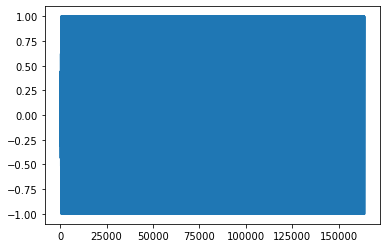

In [89]:
plt.plot(np.array(newtrack).reshape(-1))

In [101]:
IAudio(np.array(newtrack[0]).reshape(-1),rate=sr)